In [66]:
import os

import datashader as ds
import pandas as pd
from datashader import transfer_functions as tf

from functools import partial
from datashader.utils import export_image

In [53]:
ds.__version__

'0.11.0'

## Data Cleansing
Para a análise atual, iremos trabalhar apenas com as colunas referentes ao período da partida onde aconteceu o abate e as posições x e y do mapa. Além disso, algumas linhas estão preenchidas com um valor "TooEarly", provavelmente pelo abate ter acontecido cedo demais para registrar, e estas serão eliminadas do nosso dataframe. Além disso, os valores numéricos estão em formato de string, portanto, devemos transformá-los em float.

In [67]:
df = pd.read_csv('datasets/kills.csv', usecols=['Time', 'x_pos', 'y_pos'])
df.drop(df[df['x_pos'] == 'TooEarly'].index, inplace=True)
df.dropna(inplace=True)
df.rename(columns={'Time': 'time'}, inplace=True)

for col in df.columns[0:-1]:
    df[col] = df[col].apply(lambda x: float(x))
    
if not os.path.exists('images'):
    os.makedirs('images')

In [55]:
df.head()

,time,x_pos,y_pos
0,10.820,9229,8469
1,16.286,13908,5960
2,18.733,8281,7889
3,18.880,8522,8895
4,27.005,8902,7643


Verificando quais estágios do jogo compreendem o early, mid e late game.

In [56]:
df['time'].describe()
# early game: 0-16min
# mid game: 16-24min
# late game: 24 em diante

count    190823.000000
mean         24.545016
std          11.152311
min           0.845000
25%          16.018500
50%          24.637000
75%          32.174500
max          94.536000
Name: time, dtype: float64

Uma nova coluna será criada no dataframe, chamada game_phase, que irá servir de categorização para o período do jogo.

In [57]:
bins = [0, 16, 24, 32]
names = ['early_game', 'mid_game', 'late_game']
df['game_phase'] = pd.cut(df['time'], bins, labels=names)

In [58]:
df.head()

,time,x_pos,y_pos,game_phase
0,10.820,9229,8469,early_game
1,16.286,13908,5960,mid_game
2,18.733,8281,7889,mid_game
3,18.880,8522,8895,mid_game
4,27.005,8902,7643,late_game


In [61]:
canvas = ds.Canvas()
agg = canvas.points(df, 'x_pos', 'y_pos', ds.count_cat('game_phase'))
color_key = {'early_game': 'white', 'mid_game': 'lightblue', 'late_game': 'navy'}

export = partial(export_image, background="black", export_path="images")

a = export(tf.shade(agg, color_key=color_key), 'kills')

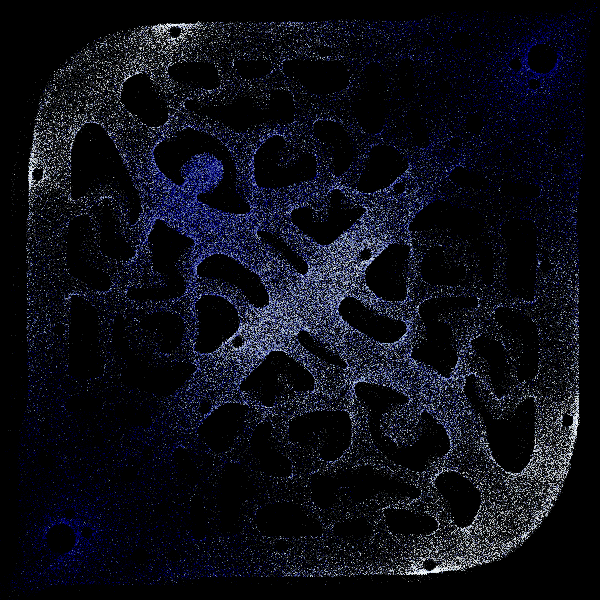

In [63]:
tf.set_background(tf.shade(agg, color_key=color_key), 'black')